# CNN Training from MNIST data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    BatchNormalization
)
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_file = "digits-mnist/digits-mnist.csv"
raw_data = np.loadtxt(
    train_file,
    skiprows=1,
    dtype='int',
    delimiter=','
)
X_train, X_test, y_train, y_test = train_test_split(
    raw_data[:,1:],
    raw_data[:,0],
    test_size=0.1
)

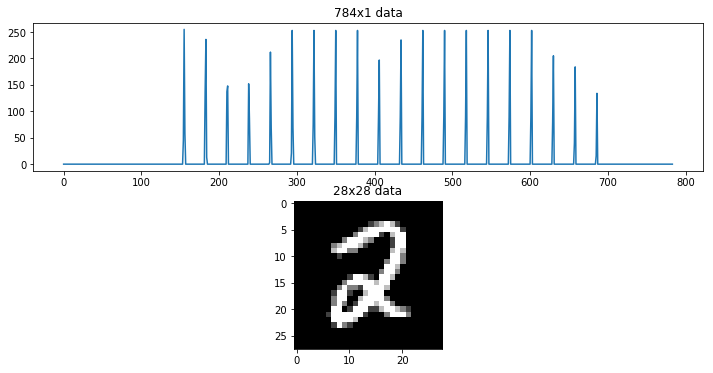

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(X_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(X_train[799].reshape(28, 28), cmap='gray')
ax[1].set_title('28x28 data')
plt.show()

In [4]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Model Training

In [5]:
cnn = Sequential()

# First Layer
cnn.add(
    Conv2D(
        filters=16,
        kernel_size=(3,3),
        activation='relu',
        input_shape=(28, 28, 1)
    )
)
cnn.add(BatchNormalization())
cnn.add(
    Conv2D(
        filters=16,
        kernel_size=(3,3),
        activation='relu',
    )
)
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(strides=(2, 2)))
cnn.add(Dropout(0.25))

In [6]:
# Second Layer
cnn.add(
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='relu',
    )
)
cnn.add(BatchNormalization())
cnn.add(
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='relu',
    )
)
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(strides=(2, 2)))
cnn.add(Dropout(0.25))

In [7]:
# Third Layer
cnn.add(Flatten())

cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.25))

cnn.add(Dense(1024, activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(10, activation='softmax'))

In [8]:
datagen = ImageDataGenerator(
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=10,
)

cnn.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=["accuracy"]
)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [9]:
hist = cnn.fit_generator(
    datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=500,
    epochs=20,
    verbose=2,
    validation_data=(X_test[:400, :], y_test[:400, :]),
    callbacks=[annealer]
)

final_loss, final_acc = cnn.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.4f}, Final accuracy: {1:.4}".format(final_loss, final_acc))

Epoch 1/20
 - 23s - loss: 0.8790 - acc: 0.7130 - val_loss: 0.1701 - val_acc: 0.9500
Epoch 2/20
 - 20s - loss: 0.3436 - acc: 0.8926 - val_loss: 0.1611 - val_acc: 0.9600
Epoch 3/20
 - 20s - loss: 0.2620 - acc: 0.9184 - val_loss: 0.1339 - val_acc: 0.9575
Epoch 4/20
 - 20s - loss: 0.2230 - acc: 0.9335 - val_loss: 0.1022 - val_acc: 0.9725
Epoch 5/20
 - 21s - loss: 0.1836 - acc: 0.9475 - val_loss: 0.1057 - val_acc: 0.9500
Epoch 6/20
 - 22s - loss: 0.1871 - acc: 0.9461 - val_loss: 0.0842 - val_acc: 0.9675
Epoch 7/20
 - 22s - loss: 0.1509 - acc: 0.9550 - val_loss: 0.0721 - val_acc: 0.9750
Epoch 8/20
 - 22s - loss: 0.1369 - acc: 0.9571 - val_loss: 0.0632 - val_acc: 0.9750
Epoch 9/20
 - 20s - loss: 0.1356 - acc: 0.9616 - val_loss: 0.0743 - val_acc: 0.9750
Epoch 10/20
 - 20s - loss: 0.1060 - acc: 0.9696 - val_loss: 0.0342 - val_acc: 0.9850
Epoch 11/20
 - 20s - loss: 0.1160 - acc: 0.9669 - val_loss: 0.0447 - val_acc: 0.9875
Epoch 12/20
 - 20s - loss: 0.1214 - acc: 0.9654 - val_loss: 0.0334 - val_a

## Model Evaluation

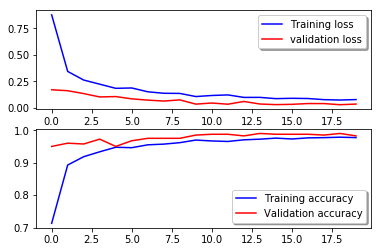

In [10]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['acc'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

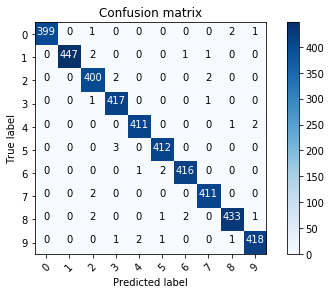

In [11]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = cnn.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))
plt.show()

In [13]:
# Save model
cnn.save('cnn-license-plate.hdf5')